# Multisim Analysis

## Configuration

In [61]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path

from multisim import MultiSim
from plotassist.plotlabelmanager import PlotLabelManager
from plotassist.groupedbarplot import GroupedBarPlot
from plotassist.deduplication import deduplicate_legend

# set plotting style
plt.style.use(['default', 'biophysics.mplstyle'])

# define and create figure save location
fig_dir = Path('figures/tm_sweep')
fig_dir.mkdir(parents=True, exist_ok=True)

# load simulation data from data folder
multisim = MultiSim(file_dir=Path('data/tm_sweep'))

In [62]:
# create a simulation averages dataframe for plotting
flen_df = pd.DataFrame([
    {
        'tau_on': sim.get_param('tau_on'),
        'tau_off': sim.get_param('tau_off'),
        'map6_on': sim.get_param('map6_on'),
        'map6_off': sim.get_param('map6_off'),
        'dt': sim.get_param('dt'),
        'fin_len': sim.get_length_at(sim.get_nsteps()-1),
        'tau_frac_tip': sim.get_tau_frac_tip(),
        'map6_frac_tip': sim.get_map6_frac_tip(),
        'tau_frac_length': sim.get_tau_frac_length(),
        'map6_frac_length': sim.get_map6_frac_length(),
        'tau_plus_end_asym': sim.get_tau_plus_end_asym(),
        'map6_plus_end_asym': sim.get_map6_plus_end_asym(),
    }
    for sim in multisim.get_iter()
])

# compute the tau map ratio
flen_df['tau/map6'] = flen_df['tau_on'] / flen_df['map6_on']

# group by the tau map ratio and compute an averages df
mean_flen_df = flen_df.groupby('tau/map6').mean()

## Growth Comparison

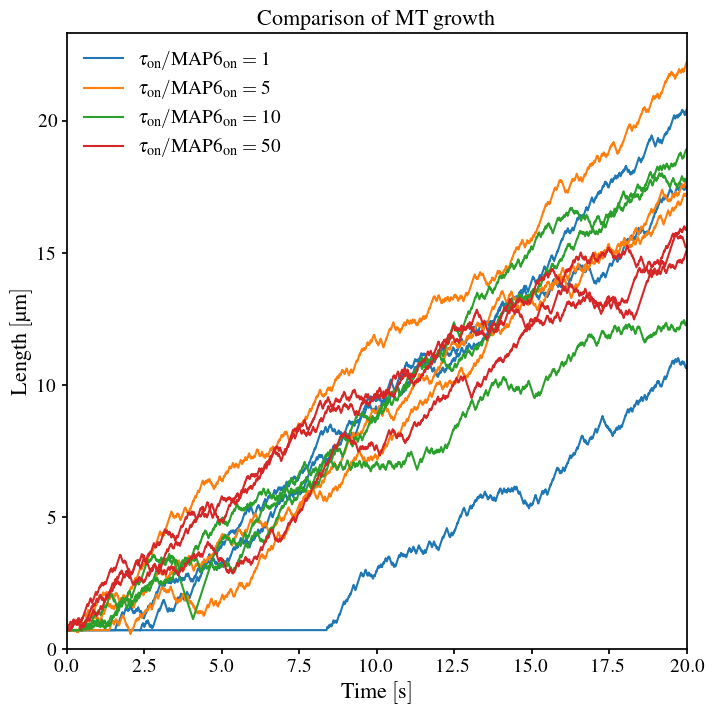

In [63]:
# plot the length of the mts over time grouped by tau_ratio
fig, ax = plt.subplots()

# define a label manager for the plot
plm = PlotLabelManager(
    args_map_dict={'color': list(plt.get_cmap('tab10').colors),
})

# sort the simulation list by the tau map ratio
sim_list = [
    [sim.get_param('tau_on') / sim.get_param('map6_on'), sim]
    for sim in multisim.get_iter()
]
sim_list.sort(key=lambda x: x[0])

# iterate over each simulation
for tm_ratio, sim in sim_list:
    # check that tm_ratio can be converted to an integer
    if np.isclose(tm_ratio % 1, 0):
        tm_ratio = int(tm_ratio)

    # generate the plot label
    # tm_ratio = sim.get_param('tau_on') / sim.get_param('map6_on')
    tm_text = r"$\tau_{\text{on}} / \text{MAP6}_{\text{on}} = " + f"{tm_ratio}$"
    plm.try_add(key=tm_ratio, text=tm_text)

    # get the time and length vectors
    time = sim.get_time_vec()
    length = sim.get_length_vec()

    # plot the time and length vectors
    ax.plot(
        time,
        length,
        **plm.get_args(tm_ratio),
    )

# force y-axis minimum to 0
ax.set_ylim(bottom=0)

# add axis labels and legend
ax.set_xlabel(r"Time $\left[\qty{}{\second}\right]$")
ax.set_ylabel(r"Length $\left[\qty{}{\micro\meter}\right]$")
ax.set_title("Comparison of MT growth")
ax.legend()

# save figure
fig_name = fig_dir / "microtubule_growth"
fig.savefig(fig_name)

## Final Length Comparison

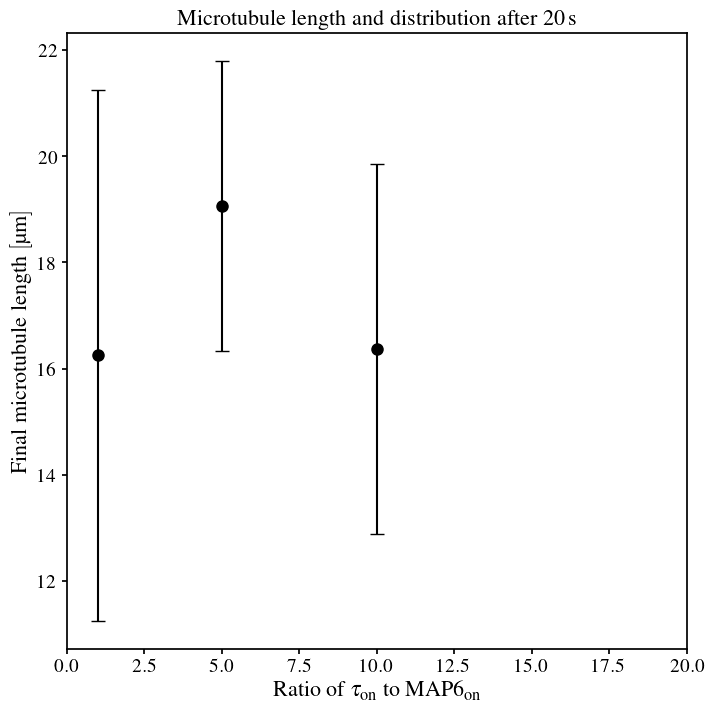

In [64]:
# plot the final length vs tau/map6
# get a data frame with just columns tau/map, fin_len
# group by tau/map6 and calculate the average fin_len and std fin_len as columns
# create a data frame for this
flen_grouped = flen_df[['tau/map6', 'fin_len']].groupby('tau/map6')
flen_stats = pd.DataFrame({
    'mean_fin_len': flen_grouped.mean()['fin_len'],
    'std_fin_len': flen_grouped.std()['fin_len'],
})

# plot with errorbars
fig, ax = plt.subplots()
ax.errorbar(
    flen_stats.index,
    flen_stats['mean_fin_len'],
    yerr=flen_stats['std_fin_len'],
    fmt='o',
    capsize=5,
    label="MT length",
    color='black'
)

# set horizontal limit
ax.set_xlim(0, 20)

# add plot labels
ax.set_xlabel(r'Ratio of $\tau_\text{on}$ to $\text{MAP6}_{\text{on}}$')
ax.set_ylabel(r'Final microtubule length $\left[\qty{}{\micro\meter}\right]$')
ax.set_title(r'Microtubule length and distribution after $\qty{20}{\second}$')

# save figure
fig_name = fig_dir / "final_length_scatter"
fig.savefig(fig_name)

## Plus-End Asymmetry

Text(0.5, 1.0, 'Comparison of protein asymmetry')

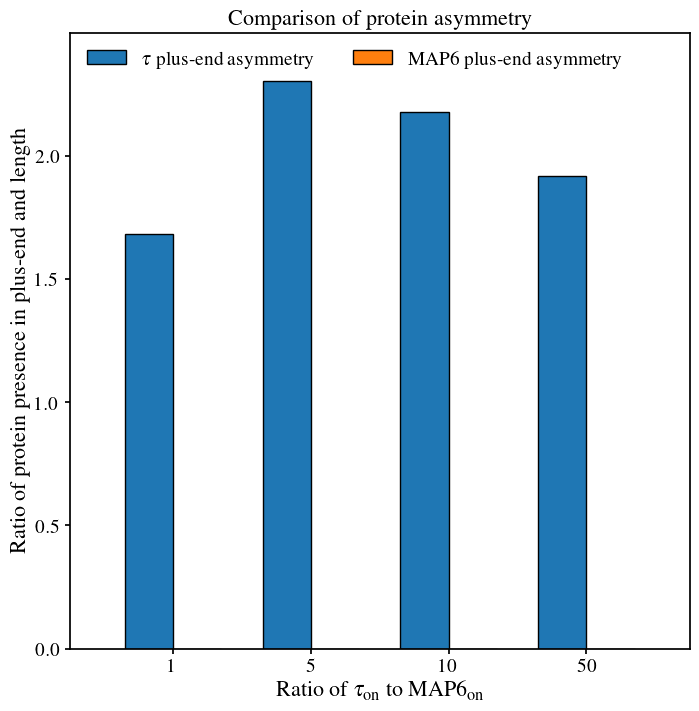

In [65]:
# get a data frame with just columns tau/map, tau_plus_end_asym, map6_plus_end_asym
asym_df = mean_flen_df[['tau_plus_end_asym', 'map6_plus_end_asym']]
asym_df.index = asym_df.index.astype(int)

# create a grouped bar plot object
bplot = GroupedBarPlot(
    asym_df,
    colormap='tab10',
    label_dict={
        'tau_plus_end_asym': r"$\tau$ plus-end asymmetry",
        'map6_plus_end_asym': r"$\text{MAP6}$ plus-end asymmetry"
    })

# create a plot
fig, ax = plt.subplots()
bplot.create_plot(ax, edgecolor='black')

# deduplicate legend entries
ax.set_ylim(top=2.5)
ax.set_yticks(ax.get_yticks()[:-1])
deduplicate_legend(ax, loc='upper left', ncols=2)

# set axis labels and title
ax.set_xlabel(r'Ratio of $\tau_\text{on}$ to $\text{MAP6}_{\text{on}}$')
ax.set_ylabel('Ratio of protein presence in plus-end and length')
ax.set_title('Comparison of protein asymmetry')

## Tau and MAP6 Distribution

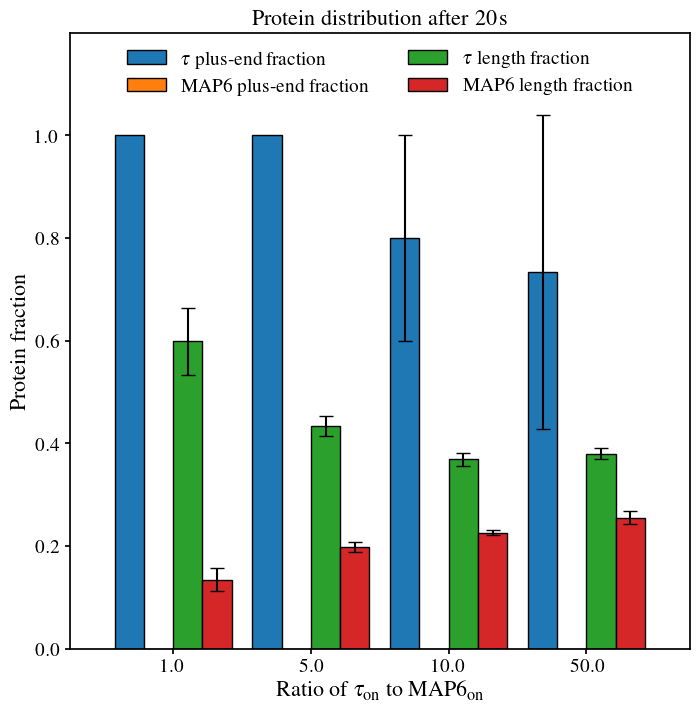

In [66]:
# define the dataframe
grouped_dist_df = flen_df[['tau/map6', 'tau_frac_tip', 'map6_frac_tip', 'tau_frac_length', 'map6_frac_length']].groupby('tau/map6')
grouped_dist_stats = pd.DataFrame({
    'mean_tau_frac_tip': grouped_dist_df.mean()['tau_frac_tip'],
    'std_tau_frac_tip': grouped_dist_df.std()['tau_frac_tip'],
    'mean_map6_frac_tip': grouped_dist_df.mean()['map6_frac_tip'],
    'std_map6_frac_tip': grouped_dist_df.std()['map6_frac_tip'],
    'mean_tau_frac_len': grouped_dist_df.mean()['tau_frac_length'],
    'std_tau_frac_len': grouped_dist_df.std()['tau_frac_length'],
    'mean_map6_frac_len': grouped_dist_df.mean()['map6_frac_length'],
    'std_map6_frac_len': grouped_dist_df.std()['map6_frac_length'],
})

# create a grouped bar plot with the mean data
bplot_mean_df = grouped_dist_stats[[
    'mean_tau_frac_tip',
    'mean_map6_frac_tip',
    'mean_tau_frac_len',
    'mean_map6_frac_len',
]]
bplot = GroupedBarPlot(
    bplot_mean_df,
    colormap='tab10',
    label_dict={
        'mean_tau_frac_tip': r'$\tau$ plus-end fraction',
        'mean_map6_frac_tip': r'$\text{MAP6}$ plus-end fraction',
        'mean_tau_frac_len': r'$\tau$ length fraction',
        'mean_map6_frac_len': r'$\text{MAP6}$ length fraction',
    }
)

# create the plot
fig, ax = plt.subplots()
bplot.create_plot(ax, edgecolor='black')

# get the bplot parameters
bplot_params = bplot.calc_axis_params()
bar_pos_dict = bplot_params['bar_pos_dict']
bar_width = bplot_params['bar_width']

# place error bars on each bar
std_df = grouped_dist_stats[['std_tau_frac_tip', 'std_map6_frac_tip', 'std_tau_frac_len', 'std_map6_frac_len']]
for _, ((_, bar_list), (_, rseries)) in enumerate(zip(bar_pos_dict.items(), std_df.iterrows())):
    for cat, pos, height in bar_list:
        # get the y-err from std_df
        yerr = rseries[cat.replace('mean', 'std')]

        # plot the error bars
        if abs(yerr) > 0:
            ax.errorbar(
                x=pos,
                y=height,
                # xerr=bar_width/2,
                yerr=yerr,
                fmt='none',
                capsize=5,
                color='black',
            )

# deduplicate legend entries and add some padding to the top of the plot
ax.set_ylim(top=1.2)
ax.set_yticks(ax.get_yticks()[:-1])
deduplicate_legend(ax, loc='upper center', ncol=2)

# add plot labels
ax.set_title(r"Protein distribution after $\qty{20}{\second}$")
ax.set_xlabel(r"Ratio of $\tau_\text{on}$ to $\text{MAP6}_\text{on}$")
ax.set_ylabel(r"Protein fraction")

# save the figure
fig_name = fig_dir / "protein_distribution"
fig.savefig(fig_name)